In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 浙江資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江3.xls')
df4 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江4.xls')
df5 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江5.xls')
df6 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江6.xls')
df7 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江7.xls')
df8 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江8.xls')
df9 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江9.xls')
df10 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江10.xls')
df11 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江11.xls')
df12 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江12.xls')
df13 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江13.xls')
df14 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江14.xls')
df15 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-浙江15.xls')

patent_df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15],ignore_index=True,sort=True)

In [10]:
print(patent_df.shape)
patent_df['申请人地址'].fillna('',inplace=True)
patent_df = patent_df[patent_df['申请人地址']!='']
print(patent_df.shape)

(677765, 39)
(654631, 39)


In [4]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'33\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [13]:
patent_df_firm.shape

(29815, 39)

In [14]:
firm_gd.shape

(34679, 6)

In [ ]:
#模糊比對待跑
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [15]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\浙江_廠商.xlsx')

# 非模糊比對

In [16]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(10064, 45)
(54430, 45)


In [17]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(25811, 50)
(45447, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [18]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\浙江_結果.xlsx')

# merge舊資料

In [5]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(3991, 45)
(39865, 45)
(17208, 50)
(39865, 50)


In [6]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\浙江_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str', 'CPC',
       'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）', '专利类型', '中国申请人区县',
       '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日', '发明人', '合享价值度',
       '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数', '摘要', '文献页数',
       '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码', '申请人类型',
       '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)', '被引证次数',
       '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '杭州', '寧波', '紹興',
       '溫州', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [7]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','杭州','寧波','紹興','溫州','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(8398, 57)

In [8]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\浙江_結果.xlsx')

# 模糊比對

In [ ]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

In [ ]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

In [ ]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\浙江_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\浙江_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\浙江_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(8398, 57)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(39865, 57)
(569, 57)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\浙江_結果.xlsx')

# 作圖

In [9]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [10]:
patent_count.sort_values()

申请人2
(杭州)浙江舞台设计研究院有限公司        1
池万毅                      1
池万焕                      1
池仁华                      1
池仁龙                      1
                     ...  
浙江理工大学                3877
浙江工业大学                5400
浙江吉利汽车研究院有限公司         5987
浙江吉利控股集团有限公司          8883
浙江大学                 16978
Name: 專利數, Length: 105134, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\浙江_結果.xlsx',index_col=0)
target1 = (30.20856,120.21181)
merge_df['杭州'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (29.89231,121.646)
merge_df['寧波'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (29.97956,120.60964)
merge_df['紹興'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (27.96501,120.72647)
merge_df['溫州'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [12]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\浙江_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (30.20856,120.21181)
target2 = (29.89231,121.646)
target3 = (29.97956,120.60964)
target4 = (27.96501,120.72647)

for i in merge_df[merge_df['杭州']==''].index:
    merge_df.loc[i,'杭州'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'寧波'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'紹興'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'溫州'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [13]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if (x['杭州']<10) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['寧波']<10)or(x['紹興']<10)or(x['溫州']<10)) else 0,axis=1)

In [14]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\浙江_結果.xlsx')

In [15]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(39865, 57)
0.5822651448639157
0.00594506459300138


In [16]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       23212
1.0        2289
2.0        1692
3.0        1000
4.0         916
5.0         691
6.0         803
7.0         687
8.0         657
9.0         519
10.0        603
11.0        449
12.0        484
13.0        396
14.0        391
15.0        344
16.0        310
17.0        287
18.0        249
19.0        232
20.0        278
21.0        195
22.0        184
23.0        151
24.0        161
25.0        166
26.0        147
27.0        154
28.0        124
29.0        104
30.0        119
31.0        129
32.0         83
33.0         75
34.0         68
35.0         65
36.0         77
37.0         58
38.0         70
39.0         48
40.0         52
41.0         48
42.0         52
43.0         53
44.0         52
45.0         33
46.0         28
47.0         29
48.0         36
49.0         21
50.0         31
51.0         32
52.0         12
53.0         23
54.0         21
55.0         14
56.0         21
57.0         22
58.0         24
59.0         14
60.0         11
61.0         10
62.0

In [17]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0      441
1.0       22
2.0       13
3.0        8
4.0        8
5.0        6
6.0        6
7.0        8
8.0        4
9.0        5
10.0       2
11.0       4
12.0       3
13.0       1
14.0       3
15.0       4
16.0       3
17.0       3
18.0       4
19.0       1
20.0       1
21.0       4
22.0       1
24.0       2
26.0       2
27.0       1
28.0       1
35.0       1
36.0       2
40.0       1
51.0       1
72.0       1
79.0       1
120.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

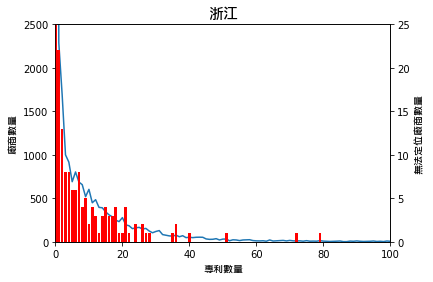

In [4]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('浙江',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,2500])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,25])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\浙江_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','公司','责任','集团','股份','控股','总公司','分公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

4952
0.12668849774866967
65


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1       970
2       678
3       384
4       336
5       241
6       237
7       207
8       173
9       155
10      129
11      122
12      119
13      100
14       75
15       67
16       69
17       67
18       65
19       39
20       48
21       43
22       28
23       28
24       32
25       28
26       28
27       36
28       29
29       18
30       24
31       24
32       24
33       13
34       10
35       12
36       14
37       10
38        9
39       10
40        9
41        6
42       16
43       12
44       11
45        7
46        3
47        5
48        7
49        4
50        6
51        3
52        2
53        2
54        6
55        4
56        6
57        1
58        5
59        3
60        2
61        2
62        5
63        2
64        4
65        3
67        3
68        3
69        2
70        1
71        1
72        3
73        1
74        1
75        3
77        1
78        3
79        5
80        2
82        1
83        3
84        1
85        2
86        1


In [4]:
not_merge[not_merge['專利數']>=1000].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,申请人地址,申请人省市代码,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,杭州,寧波,紹興,溫州,早期園區,近期園區,專利數,name_clean
38593,,,,,,,H04L9/001,H04L9/00,CN102904709A; CN102904709B; WO2014048051A1,3,,发明授权,[开化],[衢州],,CN,CN102904709B,2014-12-24 00:00:00,胡晓波; 高明; 万一农; 余成星; 陈刚; 戚益中,9,"WO, CN",,11264,CN101931526A; CN102385659A; US6396137B1; CN102694643A; CN201726386U,"<text>满峰泉 等.一组切换混沌系统的设计与电路实现.《四川兵工学报》.2009, 第30卷(第12期), </text><text>刘扬正 等.四维切换超混沌系统.《物理学报》.2007, 第56卷(第9期), </text>",...,浙江省开化县城关镇芹南路6号,浙江; 33,企业,CN201210367549.5,2012-09-27 00:00:00,WO2014048051A1; CN102904709B; CN102904709A,3,,,0,到incoPat中查看\r\nCN102904709B,国家电网公司,国家电网公司,浙江省开化县城关镇芹南路6号,1,27.9767,119.634,253.682747,289.054191,241.487938,107.496882,0,0,1007,国家电网
39417,,,,,,,,G01M99/00,CN103575557B; CN103575557A,2,0,发明授权,[北仑],[宁波],,CN,CN103575557B,2015-10-14 00:00:00,窦军营; 马国力; 安聪慧; 冯擎峰,8,CN,,4624,CN101332875A; CN101672892A; CN102431821A; CN1226728A; CN201159639Y; CN201749694U; TW200622531A; TW201135222A; US4695995A,<text>CN101332875A全文</text><text>CN101672892A全文</text><text>CN102431821A全文</text><text>CN1226728A全文</text><text>CN201159639Y全文</text><text>CN201749694U全文</text><text>TW200622531A全文</text><text>TW2...,...,浙江省宁波市经济技术开发区新碶街道恒山路1528号,浙江; 33,企业,CN201210594394.9,2012-12-31 00:00:00,CN103575557A; CN103575557B,2,,,0,到incoPat中查看\r\nCN103575557B,浙江吉利汽车有限公司,浙江吉利汽车有限公司,浙江省宁波市经济技术开发区新碶街道恒山路1528号,1,29.9011,121.863,162.798780,20.945376,121.279383,241.488618,0,0,1304,浙江吉利汽车
39387,,,,,,,,B60R22/20,CN103010150A; CN103010150B,2,,发明授权,[萧山],[杭州],,CN,CN103010150B,2015-07-22 00:00:00,贺锦鹏; 牛旭周; 马芳武; 刘卫国; 周大永; 赵福全,9,CN,,6054,,,...,浙江省杭州市萧山区临江工业园区农二场房屋206号,浙江; 33,企业,CN201210586581.2,2012-12-28 00:00:00,CN103010150B; CN103010150A,2,,,0,到incoPat中查看\r\nCN103010150B,浙江吉利汽车研究院有限公司杭州分公司,浙江吉利汽车研究院有限公司杭州分公司,浙江省杭州市萧山区临江工业园区农二场房屋206号,0,30.2286,120.375,15.824392,128.143295,35.713239,253.215544,0,0,2152,浙江吉利汽车研究院杭州分
38607,,,,,,,,C22C9/00; C22C1/10; C22F1/08; C22C32/00,CN102952962B; CN102952962A,2,0,发明授权,[临海],[台州],CN201210029251A 20120210,CN,CN102952962B,2014-09-10 00:00:00,姚再起; 李志华; 王春斌; 李莉; 刘强; 马芳武; 赵福全,9,CN,,14470,,,...,浙江省台州市临海市城东闸头,浙江; 33,企业,CN201210366802.5,2012-09-28 00:00:00,CN102952962B; CN102952962A,2,,,0,到incoPat中查看\r\nCN102952962B,浙江吉利汽车研究院有限公司,浙江吉利汽车研究院有限公司,浙江省台州市临海市城东闸头,0,28.8656,121.157,174.780841,123.313854,134.404695,108.350015,0,0,5987,浙江吉利汽车研究院
37362,,,,,,,,B60W10/06; B60W10/10; B60W10/18; B60W10/22,CN102556044A; CN102556044B,2,,发明授权,[滨江],[杭州],,CN,CN102556044B,2015-09-30 00:00:00,于立涛; 黄巧慧,10,CN,,4720,CN1221687A; CN202080272U,,...,浙江省杭州市滨江区江陵路1760号,浙江; 33,企业,CN201110454410.X,2011-12-30 00:00:00,CN102556044B; CN102556044A,2,,,0,到incoPat中查看\r\nCN102556044B,浙江吉利控股集团有限公司,浙江吉利控股集团有限公司,浙江省杭州市滨江区江陵路1760号,1,30.2075,120.218,0.609586,142.073337,45.426066,253.431039,1,0,8883,浙江吉利


Text(0.5, 0, '專利數量')

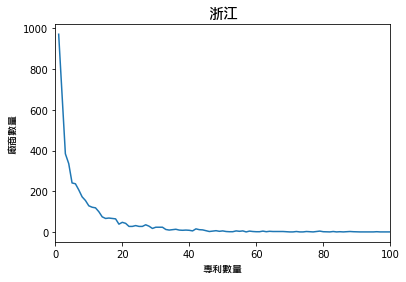

In [6]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('浙江',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [7]:
cleaned.to_excel(r'E:\paper\名稱merge\浙江_結果.xlsx')

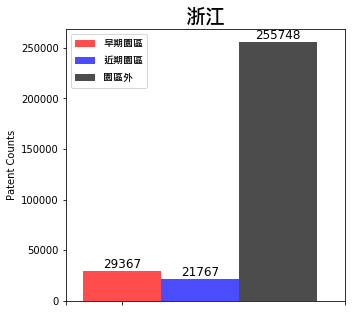

In [9]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('浙江',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

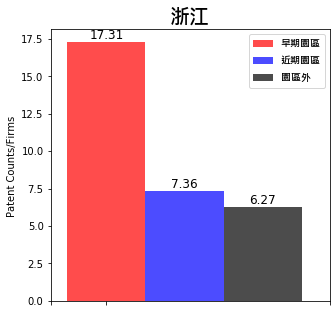

In [10]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.2f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('浙江',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)